In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar100.load_data(label_mode='fine')

In [3]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

In [4]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)


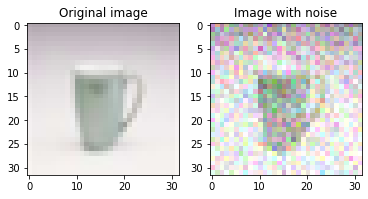

In [6]:
idx = 7
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

In [9]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [16]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='dae')

In [19]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),
       epochs=10,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.0050
Epoch 00001: val_loss improved from inf to 0.00587, saving model to best_model.h5
391/391 [==============================] - 678s 2s/step - loss: 0.0050 - val_loss: 0.0059
Epoch 2/10
155/391 [==========>...................] - ETA: 7:03 - loss: 0.0026

KeyboardInterrupt: 

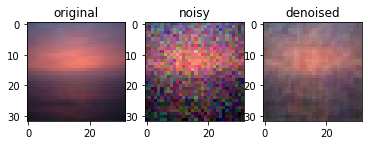

In [21]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()


In [22]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009111922791486723, 0.0058679385)

In [23]:
(cifar10_train, _), (cifar10_test, _) = cifar10.load_data()

In [24]:
ifar10_train = cifar10_train.astype('float32') / 255.
cifar10_test = cifar10_test.astype('float32') / 255.
cifar10_train_noisy = add_noise_and_clip_data(cifar10_train)
cifar10_test_noisy = add_noise_and_clip_data(cifar10_test)

In [25]:
cifar10_test_denoised = dae.predict(cifar10_test_noisy)

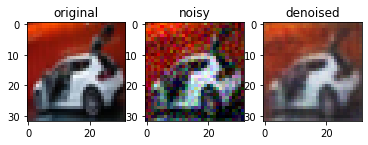

In [26]:
idx = 6
plt.subplot(1,3,1)
plt.imshow(cifar10_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(cifar10_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(cifar10_test_denoised[idx])
plt.title('denoised')
plt.show()

In [27]:
clean_noisy = mse(cifar10_test, cifar10_test_noisy)
clean_denoised = mse(cifar10_test, cifar10_test_denoised)

clean_noisy, clean_denoised

(0.009303078645547313, 0.005493185)